# The Preston Curve within the EU

Imports and set magics:

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import datetime
import pandas_datareader # install with `pip install pandas-datareader`
import pandas_datareader.data as web
import pydst # install with `pip install git+https://github.com/elben10/pydst`

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib_venn import venn2 # `pip install matplotlib-venn`

import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import regions


# Read and clean data

## Life expectancy data

**Read the life expectancy data from the Eurostat API and clean it**

In [2]:
# a. install Eurostat API
#pip install eust

# b. load
import eust
eust.download_table('demo_r_mlifexp') # downloads data on life expectancy for EU countries and their within country regions
my_tables = eust.list_tables()  # returns a list
assert 'demo_r_mlifexp' in my_tables
life = eust.read_table_data('demo_r_mlifexp') # read the dataset
life.tail(100) #distplays the tail of the dataset

print(list(life.columns)) # prints columns
print(list(life.index.names)) # prints the index

# c. reset the index
life.reset_index(level=life.index.names, inplace=True)
print(list(life.index.names))
print(list(life.columns))

# d. Only keep regions on the smallest level of aggregation (4 digits in geo code)
life = regions.only_keep_regions(life)


['value', 'flag']
['unit', 'sex', 'age', 'geo', 'time']
[None]
['unit', 'sex', 'age', 'geo', 'time', 'value', 'flag']


In [3]:
# Explore the columns

unit_life = []

for i in list(life['unit']):
    if i not in unit_life:
        unit_life.append(i)

print(unit_life)


sex_life = []

for i in list(life['sex']):
    if i not in sex_life:
        sex_life.append(i)

print(sex_life)

age_life = []

for i in list(life['age']):
    if i not in age_life:
        age_life.append(i)

print(age_life)

geo_life = []

for i in list(life['geo']):
    if i not in geo_life:
        geo_life.append(i)

print(geo_life)

year_life = []

for i in list(life['time']):
    if i not in year_life:
        year_life.append(i)

print(len(year_life))

flag_life = []

for i in list(life['flag']):
    if i not in flag_life:
        flag_life.append(i)

print(flag_life)


['YR']
['F', 'M', 'T']
['Y1', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17', 'Y18', 'Y19', 'Y2', 'Y20', 'Y21', 'Y22', 'Y23', 'Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29', 'Y3', 'Y30', 'Y31', 'Y32', 'Y33', 'Y34', 'Y35', 'Y36', 'Y37', 'Y38', 'Y39', 'Y4', 'Y40', 'Y41', 'Y42', 'Y43', 'Y44', 'Y45', 'Y46', 'Y47', 'Y48', 'Y49', 'Y5', 'Y50', 'Y51', 'Y52', 'Y53', 'Y54', 'Y55', 'Y56', 'Y57', 'Y58', 'Y59', 'Y6', 'Y60', 'Y61', 'Y62', 'Y63', 'Y64', 'Y65', 'Y66', 'Y67', 'Y68', 'Y69', 'Y7', 'Y70', 'Y71', 'Y72', 'Y73', 'Y74', 'Y75', 'Y76', 'Y77', 'Y78', 'Y79', 'Y8', 'Y80', 'Y81', 'Y82', 'Y83', 'Y84', 'Y9', 'Y_GE85', 'Y_LT1']
['AL01', 'AL02', 'AL03', 'AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34', 'BE10', 'BE21', 'BE22', 'BE23', 'BE24', 'BE25', 'BE31', 'BE32', 'BE33', 'BE34', 'BE35', 'BG31', 'BG32', 'BG33', 'BG34', 'BG41', 'BG42', 'CH01', 'CH02', 'CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CY00', 'CZ01', 'CZ02', 'CZ03', 'CZ04', 'CZ05', 'CZ06', 'CZ07', 'CZ08', 'DE11', 'DE12', '

**Only keep sex-aggregated records**

In [4]:
life = life[life['sex'].apply(lambda x: str(x) == 'T')]

**Drop columns 'unit', 'sex', and 'flag'**

In [5]:
drop_these = ['unit', 'sex', 'flag']
life.drop(drop_these, axis = 1, inplace = True)

The dataset now looks like this:

In [6]:
life.head()

,age,geo,time,value
2549100,Y1,AL01,1990,NaN
2549101,Y1,AL01,1991,NaN
2549102,Y1,AL01,1992,NaN
2549103,Y1,AL01,1993,NaN
2549104,Y1,AL01,1994,NaN


**Create individual variables for each age, i.e.e life expectancy at age x**

In [7]:
# a. start by crearing an index variable that we can keep later
life['time_s'] = life.time.apply(str)
life['index'] = life['geo'] + life['time_s']

# b. pivot table such that we get x columns for life expectancy at age x, respectively
life = life.pivot_table(index = ['geo', 'time', 'index'],
                        columns = ['age'], values = 'value').fillna(0)

# c. reset the index for geo and time
life.reset_index(level = (0,1), inplace = True)

The dataset now looks like this:

In [8]:
life.head()

age,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y79,Y8,Y80,Y81,Y82,Y83,Y84,Y9,Y_GE85,Y_LT1
index,,,,,,,,,,,,,,,,,,,,,
AL012019,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,7.9,71.7,7.4,6.8,6.2,5.7,5.2,70.7,4.8,78.7
AL022019,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,10.4,74.5,9.8,9.3,8.8,8.3,8.0,73.5,7.8,81.6
AL032019,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,5.6,70.1,4.9,4.3,3.6,3.0,2.3,69.1,1.6,77.4
AT111990,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,7.4,68.1,7.0,6.6,6.2,5.9,5.5,67.1,5.1,75.7
AT111991,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,7.5,67.5,7.0,6.6,6.2,5.9,5.5,66.5,5.3,74.8


## GDP data

**Read the GDP data from the Eurostat API and clean it**

In [9]:
# a. load
eust.download_table('nama_10r_2gdp')  # downloads data on gdp for EU countries and their within country regions
my_tables = eust.list_tables() # returns a list
assert 'nama_10r_2gdp' in my_tables
gdp = eust.read_table_data('nama_10r_2gdp') # read the dataset

print(list(gdp.columns)) # prints columns
print(list(gdp.index.names)) # prints the index

# b. reset the index
gdp.reset_index(level=gdp.index.names, inplace=True)

# c. Only keep regions on the smallest level of aggregation (4 digits in geo code)
gdp = regions.only_keep_regions(gdp)

['value', 'flag']
['unit', 'geo', 'time']


**Explore the columns**

In [10]:
unit_gdp = []

for i in list(gdp['unit']):
    if i not in unit_gdp:
        unit_gdp.append(i)

print(unit_gdp)

geo_gdp = []

for i in list(gdp['geo']):
    if i not in geo_gdp:
        geo_gdp.append(i)

print(geo_gdp)

time_gdp = []

for i in list(gdp['time']):
    if i not in time_gdp:
        time_gdp.append(i)

print(len(time_gdp))

flag_gdp = []

for i in list(gdp['flag']):
    if i not in flag_gdp:
        flag_gdp.append(i)

print(flag_gdp)


['EUR_HAB', 'EUR_HAB_EU27_2020', 'MIO_EUR', 'MIO_NAC', 'MIO_PPS_EU27_2020', 'PPS_EU27_2020_HAB', 'PPS_HAB_EU27_2020']
['AL01', 'AL02', 'AL03', 'AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34', 'BE10', 'BE21', 'BE22', 'BE23', 'BE24', 'BE25', 'BE31', 'BE32', 'BE33', 'BE34', 'BE35', 'BG31', 'BG32', 'BG33', 'BG34', 'BG41', 'BG42', 'CY00', 'CZ01', 'CZ02', 'CZ03', 'CZ04', 'CZ05', 'CZ06', 'CZ07', 'CZ08', 'DE11', 'DE12', 'DE13', 'DE14', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25', 'DE26', 'DE27', 'DE30', 'DE40', 'DE50', 'DE60', 'DE71', 'DE72', 'DE73', 'DE80', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA1', 'DEA2', 'DEA3', 'DEA4', 'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DEC0', 'DED2', 'DED4', 'DED5', 'DEE0', 'DEF0', 'DEG0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'EE00', 'EL30', 'EL41', 'EL42', 'EL43', 'EL51', 'EL52', 'EL53', 'EL54', 'EL61', 'EL62', 'EL63', 'EL64', 'EL65', 'ES11', 'ES12', 'ES13', 'ES21', 'ES22', 'ES23', 'ES24', 'ES30', 'ES41', 'ES42', 'ES43', 'ES51', 'ES52', 'ES53', 'ES61', '

**Only keep currency '[MIO_PPS_EU27_2020]' Million purchasing power standards (PPS, EU27 from 2020)**

In [11]:
gdp = gdp[gdp['unit'].apply(lambda x: str(x) == 'MIO_PPS_EU27_2020')]

**Drop columns 'unit' and 'flag'**

In [12]:
drop_these=['unit', 'flag']
gdp.drop(drop_these, axis=1, inplace=True)

**Rename variables**

In [13]:
rename_dict={}
rename_dict['value'] = 'gdp'
gdp.rename(columns=rename_dict,inplace=True)

The dataset now looks like this:

In [14]:
gdp.head()

,geo,time,gdp
33780,AL01,2000,NaN
33781,AL01,2001,NaN
33782,AL01,2002,NaN
33783,AL01,2003,NaN
33784,AL01,2004,NaN


## Education data

The column isced11 accounts for the ISCED 2011 categories for educational attainment at 1-digit level. These categories aggregate the following education levels:
Level 0 – Less than primary education
Level 1 – Primary education
Level 2 – Lower secondary education
Level 3 – Upper secondary education
Level 4 – Post-secondary non-tertiary education
Level 5 – Short-cycle tertiary education
Level 6 – Bachelor’s or equivalent level
Level 7 – Master’s or equivalent level
Level 8 – Doctoral or equivalent level.

In [15]:
# a. load
eust.download_table('edat_lfs_9917') # downloads data on education for EU countries and their within country regions
my_tables = eust.list_tables() # returns a list
assert 'edat_lfs_9917' in my_tables
education = eust.read_table_data('edat_lfs_9917') # read the dataset

print(list(education.columns)) # prints the columns
print(list(education.index.names)) # prints the index

# b. reset the index
education.reset_index(level=education.index.names, inplace=True)

# c. only keep regions on the smallest level of aggregation (4 digits in geo code)
education = regions.only_keep_regions(education)

['value', 'flag']
['unit', 'sex', 'isced11', 'c_birth', 'age', 'geo', 'time']


**Exploring the dataset**

In [16]:
unit_ed = []

for i in list(education['unit']):
    if i not in unit_ed:
        unit_ed.append(i)

print(unit_ed)

sex_ed = []

for i in list(education['sex']):
    if i not in sex_ed:
        sex_ed.append(i)

print(sex_ed)

isced11_ed = []

for i in list(education['isced11']):
    if i not in isced11_ed:
        isced11_ed.append(i)

print(isced11_ed)

c_birth_ed = []

for i in list(education['c_birth']):
    if i not in c_birth_ed:
        c_birth_ed.append(i)

print(c_birth_ed)


age_ed = []

for i in list(education['age']):
    if i not in age_ed:
        age_ed.append(i)

print(age_ed)

geo_ed = []

for i in list(education['geo']):
    if i not in geo_ed:
        geo_ed.append(i)

print(geo_ed)

time_ed = []

for i in list(education['time']):
    if i not in time_ed:
        time_ed.append(i)

print(time_ed)

flag_ed = []

for i in list(education['flag']):
    if i not in flag_ed:
        flag_ed.append(i)

print(flag_ed)

['PC']
['F', 'M', 'T']
['ED0-2', 'ED3-8', 'ED3_4', 'ED5-8']
['EU15_FOR', 'EU27_2020_FOR', 'EU28_FOR', 'FOR', 'NAT', 'NEU15_FOR', 'NEU27_2020_FOR', 'NEU28_FOR', 'NRP', 'TOTAL']
['Y15-64', 'Y25-64']
['AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34', 'BE10', 'BE21', 'BE22', 'BE23', 'BE24', 'BE25', 'BE31', 'BE32', 'BE33', 'BE34', 'BE35', 'BG31', 'BG33', 'BG34', 'BG41', 'BG42', 'CH01', 'CH02', 'CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CY00', 'CZ01', 'CZ02', 'CZ03', 'CZ04', 'CZ05', 'CZ06', 'CZ07', 'CZ08', 'DE11', 'DE12', 'DE13', 'DE14', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25', 'DE26', 'DE27', 'DE30', 'DE40', 'DE50', 'DE60', 'DE71', 'DE72', 'DE73', 'DE80', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA1', 'DEA2', 'DEA3', 'DEA4', 'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DEC0', 'DED2', 'DED4', 'DED5', 'DEE0', 'DEF0', 'DEG0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'EA19', 'EE00', 'EL30', 'EL41', 'EL42', 'EL43', 'EL51', 'EL52', 'EL53', 'EL54', 'EL61', 'EL62', 'EL63', 'EL64', 'EL65', 'ES11', 'E

**Only keep sex-aggregated records**

In [17]:
education = education[education['sex'].apply(lambda x: str(x) == 'T')]

**Only keep isced11 aggregation levels ED0-2, ED3-4, ED5-8**

In [18]:
# a. names of indexes where education is ED3-8
indexname = education[ education['isced11'] == 'ED3-8'].index

# b. delete these row indexes from education
education.drop(indexname , inplace=True)

# c. checkt the remaining aggregation levels
isced11_ed_new = []

for i in list(education['isced11']):
    if i not in isced11_ed_new:
        isced11_ed_new.append(i)

print(isced11_ed_new)


['ED0-2', 'ED3_4', 'ED5-8']


**Create individual variables for each of the aggregation levels, i.e., for ED0_2, ED3_4, and ED_5-8**

In [19]:
# a. start by crearing an index variable that we can keep later
education['time_s'] = education.time.apply(str)
education['index']= education['geo'] + education['time_s']


# b. pivot table such that we get 3 columns for ED0_2, ED3-4, and ED5-8, respectively
education = education.pivot_table(index=['geo', 'time', 'index'],
                        columns=['isced11'], values='value').fillna(0)

# c. reset the index for geo and time
education.reset_index(level = (0,1), inplace = True)

**Rename the education variables**

In [20]:
rename_dict['ED0-2'] = 'ED0_2'
rename_dict['ED5-8'] = 'ED5_8'
education.rename(columns=rename_dict,inplace=True)

The dataset now looks like this:

In [21]:
education.head()

isced11,geo,time,ED0_2,ED3_4,ED5_8
index,,,,,
AT112004,AT11,2004,26.550000,55.966667,12.375
AT112005,AT11,2005,28.514286,57.275000,11.625
AT112006,AT11,2006,25.600000,58.331250,13.600
AT112007,AT11,2007,29.910000,60.881250,12.425
AT112008,AT11,2008,24.366667,61.460000,13.100


## Population data

In [22]:
# a. load
eust.download_table('nama_10r_3popgdp') # downloads data on the population for EU countries and their within country regions
my_tables = eust.list_tables() # returns a list
assert 'nama_10r_3popgdp' in my_tables
pop = eust.read_table_data('nama_10r_3popgdp') # reads the data

print(list(pop.columns))
print(list(pop.index.names))

# b. reset the index
pop.reset_index(level=pop.index.names, inplace=True)

# c. only keep regions on the smallest level of aggregation (4 digits in geo code)
pop = regions.only_keep_regions(pop)


['value', 'flag']
['unit', 'geo', 'time']


**Exploring the dataset**

In [23]:
unit_pop = []

for i in list(pop['unit']):
    if i not in unit_pop:
        unit_pop.append(i)

print(unit_ed)


geo_pop = []

for i in list(pop['geo']):
    if i not in geo_pop:
        geo_pop.append(i)

print(geo_pop)

time_pop = []

for i in list(pop['time']):
    if i not in time_pop:
        time_pop.append(i)

print(time_pop)

flag_pop = []

for i in list(pop['flag']):
    if i not in flag_pop:
        flag_pop.append(i)

print(flag_pop)

['PC']
['AL01', 'AL02', 'AL03', 'AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34', 'ATZZ', 'BE10', 'BE21', 'BE22', 'BE23', 'BE24', 'BE25', 'BE31', 'BE32', 'BE33', 'BE34', 'BE35', 'BG31', 'BG32', 'BG33', 'BG34', 'BG41', 'BG42', 'CY00', 'CZ01', 'CZ02', 'CZ03', 'CZ04', 'CZ05', 'CZ06', 'CZ07', 'CZ08', 'DE11', 'DE12', 'DE13', 'DE14', 'DE21', 'DE22', 'DE23', 'DE24', 'DE25', 'DE26', 'DE27', 'DE30', 'DE40', 'DE50', 'DE60', 'DE71', 'DE72', 'DE73', 'DE80', 'DE91', 'DE92', 'DE93', 'DE94', 'DEA1', 'DEA2', 'DEA3', 'DEA4', 'DEA5', 'DEB1', 'DEB2', 'DEB3', 'DEC0', 'DED2', 'DED4', 'DED5', 'DEE0', 'DEF0', 'DEG0', 'DK01', 'DK02', 'DK03', 'DK04', 'DK05', 'DKZZ', 'EE00', 'EL30', 'EL41', 'EL42', 'EL43', 'EL51', 'EL52', 'EL53', 'EL54', 'EL61', 'EL62', 'EL63', 'EL64', 'EL65', 'ES11', 'ES12', 'ES13', 'ES21', 'ES22', 'ES23', 'ES24', 'ES30', 'ES41', 'ES42', 'ES43', 'ES51', 'ES52', 'ES53', 'ES61', 'ES62', 'ES63', 'ES64', 'ES70', 'ESZZ', 'FI19', 'FI1B', 'FI1C', 'FI1D', 'FI20', 'FR10', 'FRB0', 

**Drop 'unit' and 'flag' and rename the outcome variable**

In [24]:
# a. drop columns
drop_these = ['unit', 'flag']
pop.drop(drop_these, axis=1, inplace=True)

# b. rename columns
rename_dict['value'] = 'pop'
pop.rename(columns=rename_dict,inplace=True)

The dataset now looks like this:

In [25]:
pop.head()

,geo,time,pop
40,AL01,2000,NaN
41,AL01,2001,NaN
42,AL01,2002,NaN
43,AL01,2003,NaN
44,AL01,2004,NaN


## Explore all four data sets together

In order to be able to **explore the raw data**, we here provide an **interactive plot** to show, respectively, life expectancy, GDP, education, and population in each geographical area

The **static plot** is:

In [26]:
def plot_all(life, gdp, education, pop, dataset, geo): 
    
    if dataset == 'Life expectancy':
        df = life
        y = ['Y_LT1', 'Y65', 'Y_GE85']
    elif dataset == 'GDP':
        df = gdp
        y = 'gdp'
    elif dataset == 'Education':
        df = education
        y = ['ED0_2', 'ED3_4', 'ED5_8']
    else:
        df = pop
        y = 'pop'
    
    I = df['geo'] == geo
    ax = df.loc[I,:].plot(x='time', y=y, style='-o')

In [27]:
widgets.interact(plot_all, 
    
    
    life = widgets.fixed(life),
    gdp = widgets.fixed(gdp),
    education = widgets.fixed(education),
    pop = widgets.fixed(pop),
    dataset = widgets.Dropdown(description='Dataset', 
                               options=['Life expectancy','GDP', 'Education', 'Population']),
    geo = widgets.Dropdown(description='Geographical area', 
                                    options=gdp.geo.unique())
                 
); 

interactive(children=(Dropdown(description='Dataset', options=('Life expectancy', 'GDP', 'Education', 'Populat…

# Merging data sets

We now create a data set with **areas which are at least in our life expectancy data set**.

**We first illustrate that all four datasets have overlapping geographical areas by displaying venn diagrams:**

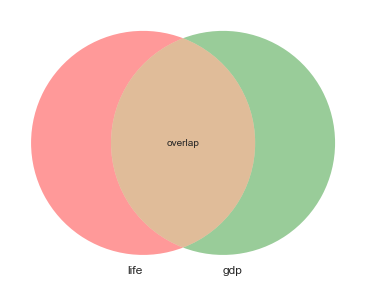

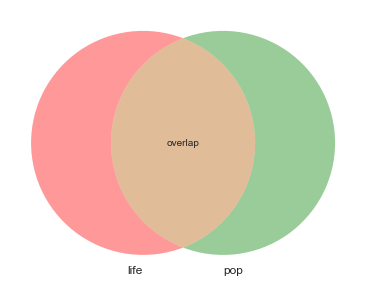

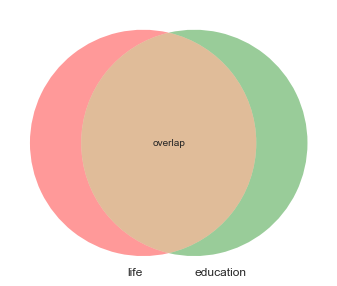

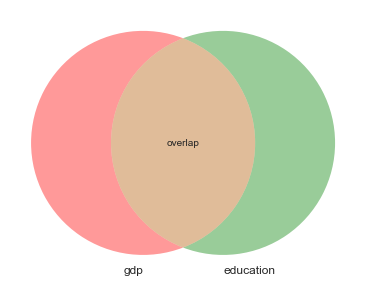

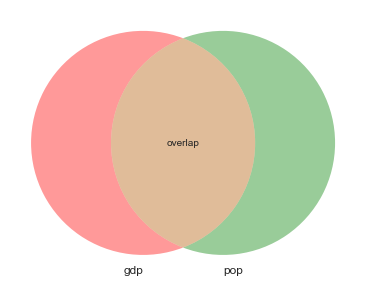

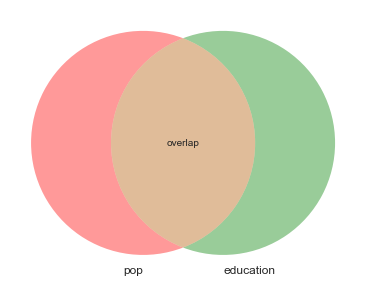

In [28]:
plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 5), set_labels = ('life', 'gdp'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 5), set_labels = ('life', 'pop'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 10), set_labels = ('life', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 5), set_labels = ('gdp', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 5), set_labels = ('gdp', 'pop'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()

plt.figure(figsize=(10,5))
v = venn2(subsets = (4, 4, 5), set_labels = ('pop', 'education'))
v.get_label_by_id('100').set_text('')
v.get_label_by_id('010').set_text('' )
v.get_label_by_id('110').set_text('overlap')
plt.show()


**We now merge all four data sets**

In [29]:
# a. merge dataset life and gdp
dataset_1 = pd.merge(life, gdp, on=['geo', 'time'], how='left')
dataset_1.head(5)

# b. merge with dataset education
dataset_2 = pd.merge(dataset_1, education, on=['geo', 'time'], how='left')
dataset_2.head(5)

# c. merge with dataset pop
ds = pd.merge(dataset_2, pop, on=['geo', 'time'], how='left')


print(f'Number of geographical areas = {len(ds.geo.unique())}')
print(f'Number of years              = {len(ds.time.unique())}')

ds.head(100)

Number of geographical areas = 332
Number of years              = 30


,geo,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,...,Y83,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop
0,AL01,2019,78.5,69.7,68.8,67.8,66.8,65.9,64.9,63.9,...,5.7,5.2,70.7,4.8,78.7,NaN,NaN,NaN,NaN,NaN
1,AL02,2019,81.5,72.6,71.6,70.6,69.6,68.6,67.6,66.6,...,8.3,8.0,73.5,7.8,81.6,NaN,NaN,NaN,NaN,NaN
2,AL03,2019,77.0,68.1,67.1,66.2,65.2,64.2,63.2,62.2,...,3.0,2.3,69.1,1.6,77.4,NaN,NaN,NaN,NaN,NaN
3,AT11,1990,75.0,66.1,65.1,64.1,63.1,62.1,61.2,60.2,...,5.9,5.5,67.1,5.1,75.7,NaN,NaN,NaN,NaN,NaN
4,AT11,1991,74.3,65.5,64.5,63.5,62.5,61.6,60.6,59.6,...,5.9,5.5,66.5,5.3,74.8,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,AT21,1996,77.4,68.6,67.6,66.6,65.6,64.6,63.6,62.6,...,6.6,6.2,69.6,5.8,78.0,NaN,NaN,NaN,NaN,NaN
96,AT21,1997,77.5,68.6,67.7,66.7,65.7,64.7,63.7,62.7,...,6.7,6.3,69.6,6.0,78.1,NaN,NaN,NaN,NaN,NaN
97,AT21,1998,78.2,69.3,68.3,67.3,66.3,65.3,64.4,63.4,...,6.8,6.4,70.3,6.0,78.9,NaN,NaN,NaN,NaN,NaN
98,AT21,1999,77.7,68.9,67.9,66.9,65.9,64.9,64.0,63.0,...,6.9,6.5,69.9,6.1,78.5,NaN,NaN,NaN,NaN,NaN


# Analysis

**Calculate GDP per capita**

In [30]:
ds['gdp_pc'] = ds['gdp']/ds['pop']
ds['time'] = pd.to_numeric(ds['time'])

**Summary statistics**

In [31]:
ds.describe()

,time,Y1,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,...,Y84,Y9,Y_GE85,Y_LT1,gdp,ED0_2,ED3_4,ED5_8,pop,gdp_pc
count,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,7413.000000,...,7413.000000,7413.000000,7413.000000,7413.000000,4445.000000,4677.000000,4677.000000,4677.000000,4810.000000,4444.000000
mean,2006.582086,78.339053,69.466410,68.474585,67.483043,66.491744,65.501862,64.513962,63.529583,62.548698,...,6.626319,70.458478,6.216134,78.937637,44397.147231,32.192597,43.550149,25.632914,1890.184782,23.697353
std,8.257912,2.931996,2.882124,2.878725,2.876474,2.873913,2.871002,2.867280,2.863878,2.859285,...,0.867787,2.884893,0.830519,3.092512,51766.292346,14.907194,12.619536,10.558605,1686.150361,10.388389
min,1990.000000,66.600000,57.900000,56.900000,55.900000,54.900000,54.000000,53.000000,52.000000,51.100000,...,2.300000,58.800000,1.600000,66.600000,681.550000,4.800000,0.000000,0.000000,25.740000,4.008169
25%,2000.000000,76.900000,68.000000,67.000000,66.000000,65.100000,64.100000,63.100000,62.100000,61.100000,...,6.100000,69.000000,5.700000,77.400000,15366.150000,22.043750,34.955556,17.938889,849.865000,16.296940
50%,2007.000000,78.800000,69.900000,68.900000,67.900000,66.900000,65.900000,64.900000,64.000000,63.000000,...,6.700000,70.900000,6.200000,79.400000,29596.230000,28.610526,42.593750,24.405263,1447.545000,22.616030
75%,2014.000000,80.500000,71.500000,70.600000,69.600000,68.600000,67.600000,66.600000,65.600000,64.600000,...,7.100000,72.500000,6.700000,81.200000,53082.180000,40.888889,53.266667,31.655556,2357.552500,29.514308
max,2019.000000,85.000000,76.000000,75.000000,74.000000,73.000000,72.000000,71.000000,70.000000,69.000000,...,9.800000,77.000000,9.600000,85.800000,679085.940000,88.816667,81.008333,75.683333,15293.410000,81.046211


To get a quick overview of the data, we show some **summary statistics by year**:

In [32]:
ds.groupby('time').agg(['mean','std']).round(2)

Y1          Y10          Y11          Y12          Y13        ...  \
       mean   std   mean   std   mean   std   mean   std   mean   std  ...   
time                                                                   ...   
1990  75.43  2.47  66.66  2.37  65.67  2.37  64.69  2.37  63.70  2.36  ...   
1991  75.34  2.68  66.56  2.60  65.57  2.60  64.59  2.59  63.60  2.60  ...   
1992  75.37  2.83  66.57  2.76  65.59  2.75  64.60  2.75  63.61  2.75  ...   
1993  75.71  2.60  66.90  2.55  65.91  2.55  64.92  2.54  63.93  2.54  ...   
1994  76.06  2.66  67.24  2.60  66.25  2.60  65.27  2.60  64.28  2.60  ...   
1995  75.93  2.88  67.11  2.81  66.12  2.81  65.14  2.80  64.15  2.80  ...   
1996  76.18  2.81  67.36  2.75  66.37  2.74  65.38  2.74  64.39  2.73  ...   
1997  76.49  2.72  67.66  2.67  66.67  2.67  65.68  2.67  64.69  2.66  ...   
1998  76.65  2.70  67.80  2.66  66.81  2.65  65.82  2.65  64.84  2.65  ...   
1999  76.90  2.46  68.04  2.42  67.05  2.42  66.06  2.42  65.07  2.42  ...   
2000  77.18  2.40  68.31  2.37  67.32  2.37  66.33  2.37  65.34  2.37  ...   
2001  77.61  2.38  68.73  2.35  67.74  2.34  66.75  2.34  65.76  2.34  ...   
2002  77.54  2.32  68.67  2.30  67.68  2.30  66.68  2.30  65.69  2.29  ...   
2003  77.57  2.28  68.69  2.26  67.70  2.26  66.71  2.26  65.72  2.25  ...   
2004  77.96  2.55  69.07  2.51  68.08  2.52  67.09  2.52  66.10  2.51  ...   
2005  78.03  2.59  69.16  2.55  68.17  2.55  67.17  2.55  66.18  2.55  ...   
2006  78.45  2.65  69.56  2.62  68.57  2.62  67.57  2.62  66.58  2.62  ...   
2007  78.62  2.63  69.73  2.60  68.74  2.60  67.75  2.60  66.75  2.60  ...   
2008  78.81  2.54  69.92  2.52  68.92  2.52  67.94  2.52  66.94  2.51  ...   
2009  78.81  2.57  69.94  2.52  68.95  2.51  67.96  2.51  66.97  2.50  ...   
2010  79.10  2.54  70.23  2.49  69.24  2.48  68.25  2.48  67.25  2.48  ...   
2011  79.37  2.47  70.50  2.42  69.50  2.42  68.51  2.41  67.52  2.42  ...   
2012  79.46  2.35  70.57  2.32  69.57  2.32  68.58  2.32  67.58  2.31  ...   
2013  79.72  2.32  70.83  2.29  69.83  2.29  68.84  2.29  67.84  2.28  ...   
2014  79.99  2.41  71.09  2.38  70.09  2.38  69.10  2.38  68.11  2.38  ...   
2015  79.75  2.33  70.84  2.30  69.85  2.30  68.86  2.29  67.87  2.29  ...   
2016  80.05  2.36  71.14  2.33  70.15  2.33  69.16  2.33  68.16  2.33  ...   
2017  79.98  2.41  71.07  2.38  70.08  2.38  69.08  2.38  68.09  2.38  ...   
2018  80.08  2.44  71.17  2.41  70.18  2.41  69.19  2.41  68.19  2.41  ...   
2019  80.26  2.54  71.35  2.51  70.36  2.51  69.37  2.51  68.37  2.51  ...   

      ED0_2         ED3_4         ED5_8             pop          gdp_pc         
       mean    std   mean    std   mean    std     mean      std   mean    std  
time                                                                            
1990    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1991    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1992    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1993    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1994    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1995    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1996    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1997    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1998    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
1999    NaN    NaN    NaN    NaN    NaN    NaN      NaN      NaN    NaN    NaN  
2000    NaN    NaN    NaN    NaN    NaN    NaN  1725.00  1674.76  17.06   7.83  
2001    NaN    NaN    NaN    NaN    NaN    NaN  1684.38  1639.02  18.92   7.95  
2002    NaN    NaN    NaN    NaN    NaN    NaN  1805.47  1561.00  19.74   8.10  
2003    NaN    NaN    NaN    NaN    NaN    NaN  1805.66  1575.00  20.35   8.10  
2004  35.02  13.68  45.09  12.66  20.83   8.07  1853.44  

## We now create a widget that allows us to plot all columns against each other

In [33]:
# variables not to plot
ex = ['time', 'geo']

# variables to plot
var_list = [element for element in ds.columns if element not in ex]
def series(year, x_axis = 'gdp_pc', y_axis = 'Y_1'):
    '''
    A function that scatters the chosen variables within the data set.
    scaled such that a larger dots represents a larger population.
    '''
    
    for i in range(year):
        # slicing the data set by year for the slider
        ds_ = ds[ds['time'] == i ]
        # the x and y axis of choice
        x=ds_[str(x_axis)]
        y=ds_[str(y_axis)]
        # scaling the dots
        population = ds_['pop']/100
    plt.scatter(x,y,s=population )
    plt.xlabel(str(x_axis))
    plt.ylabel(str(y_axis))
    plt.title(f' The relationship between {x_axis} and {y_axis}',loc='center')
    return()
interact(series, year=(min(list(ds['time'])),max(list(ds['time'])),1), x_axis=var_list, y_axis=var_list);

interactive(children=(IntSlider(value=2004, description='year', max=2019, min=1990), Dropdown(description='x_a…

We can see that when plotting GDP per capita against life expectancy, we find a positive relationship between the two. Based on this graphical analysis we confirm that the Preston Curve also exists across regions within the EU. The relationship between GDP per capita and education, as well as between education and life expectancy is less clear. Still, when considering the percentage of the population who attained education levels equivalent to at least some form of tertiary education (levels 5-8), we find a positive relationship between education and life expectancy as well as between GDP per capita and education.

## We can also present the relationship with regression lines of various orders

In [34]:
# variables not to plot
ex = ['time', 'geo']

# variables to plot
var_list = [element for element in ds.columns if element not in ex]
def series2(year, order, x_axis = 'gdp_pc', y_axis = 'Y1'):
    '''
    A function that plots regression lines 
    for the chosen variables and at a chosen order of polynomial
    for a chosen year
    '''
    for i in range(year):
        #slicing the data set by year for the slider
        ds_ = ds[ds['time'] == i ]
        # the x and y axis of choice
        x=ds_[str(x_axis)]
        y=ds_[str(y_axis)]
        population = ds_['pop']/100
    for o in range(order):
        #plotting regression at the chosen order polynomial
        sns.regplot(x=x, y=y, data=ds_,
                 scatter_kws={"s": 80},
                    order=o, ci=None).set_title(f'polynomial fits between {x_axis} and {y_axis}')
    return()
interact(series2, year=(min(list(ds['time'])),max(list(ds['time'])),1), order=(0,5,1), x_axis=var_list, y_axis=var_list);




interactive(children=(IntSlider(value=2004, description='year', max=2019, min=1990), IntSlider(value=2, descri…

We see that some of the variation is better explained with higher order regressions. Therefore we run two regressions, one linear and one polynomial. For life expectancy at birth with GDP per capita and with share of highly educated as well as for the share of highly educated and GDP per capita.

In [35]:
# defining squared versions of the variables for the second order regressions
ds['gdp_pc_sq'] = ds['gdp_pc']**2
ds['ED5_8_sq'] = ds['ED5_8']**2

# preparing the data for regression
dfgg = ds.groupby(['Y1', 'gdp_pc', 'gdp_pc_sq', 'ED5_8']).mean().reset_index()


# running the regressions

reg1 = smf.ols('Y1 ~ gdp_pc',
              dfgg).fit()

reg2 = smf.ols('Y1 ~ gdp_pc + gdp_pc_sq',
              dfgg).fit()

reg3 = smf.ols('Y1 ~ ED5_8',
              dfgg).fit()

reg4 = smf.ols('Y1 ~ ED5_8 + ED5_8_sq',
              dfgg).fit()

reg5 = smf.ols('ED5_8 ~ gdp_pc',
              dfgg).fit()

reg6 = smf.ols('ED5_8 ~ gdp_pc + gdp_pc_sq',
              dfgg).fit()

# printing summaries 
print(reg1.summary())
print(reg2.summary())
print(reg3.summary())
print(reg4.summary())
print(reg5.summary())
print(reg6.summary())



                            OLS Regression Results                            
Dep. Variable:                     Y1   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1841.
Date:                Sun, 11 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:43:26   Log-Likelihood:                -8212.4
No. Observations:                3739   AIC:                         1.643e+04
Df Residuals:                    3737   BIC:                         1.644e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.5424      0.090    836.463      0.0

In [36]:
print(f'Life expectancy and GDP pc \n\nParameters for the single linear regression: \n{reg1.params}')
print(f'The r sqared:\n{reg1.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg2.params}')
print(f'The r sqared:\n{reg2.rsquared}')

print(f'\n\nLife expectancy and education \n\nParameters for the single linear regression: \n{reg3.params}')
print(f'The r sqared:\n{reg3.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg4.params}')
print(f'The r sqared:\n{reg4.rsquared}')

print(f'\n\nEducation and GDP pc \n\nParameters for the single linear regression: \n{reg3.params}')
print(f'The r sqared:\n{reg5.rsquared}')

print(f'The coefficient of interest for the polynomial regression:\n{reg6.params}')
print(f'The r sqared:\n{reg6.rsquared}')


Life expectancy and GDP pc 

Parameters for the single linear regression: 
Intercept    75.542425
gdp_pc        0.144959
dtype: float64
The r sqared:
0.3300003543723605
The coefficient of interest for the polynomial regression:
Intercept    71.634577
gdp_pc        0.460355
gdp_pc_sq    -0.005375
dtype: float64
The r sqared:
0.4744792205185293


Life expectancy and education 

Parameters for the single linear regression: 
Intercept    77.122011
ED5_8         0.084072
dtype: float64
The r sqared:
0.08972424758313513
The coefficient of interest for the polynomial regression:
Intercept    75.344835
ED5_8         0.237838
ED5_8_sq     -0.002862
dtype: float64
The r sqared:
0.10884657429283817


Education and GDP pc 

Parameters for the single linear regression: 
Intercept    77.122011
ED5_8         0.084072
dtype: float64
The r sqared:
0.3124630696593551
The coefficient of interest for the polynomial regression:
Intercept    10.501491
gdp_pc        0.560705
gdp_pc_sq    -0.000991
dtype: flo

# Conclusion

This assignment sought to explore the relationship between life expectancy and real GDP per capita, life expectancy and education, as well as education and GDP per capita, using cross-sectional data on different regions within European countries drawn from the database Eurostat. 

We use four different data sets: One on life expectancy, one on GDP, one on population, and one on education level.

Then then merge the datasets and calculate real GDP per capita.

We found that it was indeed possible to find the Preston Curve within Europe using the aforementioned data; both graphically as well as by running regressions. We find significant and positive coefficients on GDP per capita and GDP per capita squared. However, we should also be concerned with confounding variables and omitted variable bias which could break down the causality analysis. 

We use life expectancy as a proxy for health such that we can show a prositive relationship between health and GDP per capita. However, one could argue that the causality direction is reverse such that better health as proxied by life expectancy causes higher incomes because a healthier population on average tends to be more productive than does a less healthy population. Better health may also influence GDP per capita through its effect on education. This is plausible as we find positive and significant estimate on education when this is regressed on GDP per capita – both linearly and squared. Hence, we cannot draw a clear conlcusion on the direction of causality.